In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztoolz as viz
import mltoolz as mlt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
train = pd.read_csv('../data/raw/train.csv')

In [ ]:
# Transform 'PassengerId'
def transform_passengerId(df):
    df['GroupId'] = df['PassengerId'].str.split('_').str[0]
    df['PassengerNumber'] = df['PassengerId'].str.split('_').str[1].astype(float)
    group_counts = df['GroupId'].value_counts()
    df['GroupSize'] = df['GroupId'].map(group_counts)
    df['InGroup'] = np.where(df['GroupSize'] > 1, 1, 0)
    return df

# Transform 'Cabin'
def transform_Cabin(df):
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Side'] = df['Cabin'].str.split('/').str[2]
    bin_edges = np.linspace(df['CabinNumber'].min(), df['CabinNumber'].max(), 5)
    df['CabinPosition'] = pd.cut(df['CabinNumber'],
                                 bins=bin_edges,
                                 labels=['Front','Second','Third','Back'],
                                 include_lowest=True)
    return df

# Imputations for NaNs in 'HomePlanet'
def impute_homePlanet(df):
    group_modes = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = group_modes[df['HomePlanet'].isna()]

    deck_modes = df.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[df['HomePlanet'].isna()]

    if 'VIP' in df.columns:
        vip_mode_homePlanet = df.loc[df['VIP'] == True, 'HomePlanet'].mode().iloc[0]
        df.loc[df['VIP'] & df['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

    df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0], inplace=True)

    return df

# Proportional imputer for categorical columns
def proportional_imputer(df, impute_cols):
    for col in impute_cols:
        proportions = df.groupby('HomePlanet')[col].value_counts(normalize=True)

        def impute_values(row):
            if pd.isna(row[col]):
                group = row['HomePlanet']
                if pd.notna(group) and group in proportions.index:
                    group_proportions = proportions.loc[group].dropna()
                    return np.random.choice(group_proportions.index, p=group_proportions.values)
            return row[col]
        
        # Apply the impute function to each column
        df[col] = df.apply(impute_values, axis=1)
    return df

# KNN imputation for numerical columns
def knn_imputer(df, columns):
    imputer = KNNImputer(n_neighbors=5)
    df[columns] = imputer.fit_transform(df[columns])
    return df

# Create 'TotalSpent' feature
def create_totalSpent(df):
    df['TotalSpent'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
    return df

# Convert specific columns to integers
def convert_to_int(df):
    for col in ['InGroup', 'CryoSleep', 'VIP', 'Transported']:
        if col in df.columns:
            df[col] = df[col].astype(int)
    return df

# Drop unwanted columns
def drop_cols(df):
    droppers = ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name']
    df.drop(droppers, axis=1, inplace=True)
    return df

# Main function to process DataFrame in order
def process_dataframe(df):
    df = transform_passengerId(df)
    df = transform_Cabin(df)
    df = impute_homePlanet(df)
    df = proportional_imputer(df, impute_cols=['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep'])
    df = knn_imputer(df, columns=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
    df = create_totalSpent(df)
    df = convert_to_int(df)
    df = drop_cols(df)
    return df

In [ ]:
process_dataframe(train)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,InGroup,Deck,Side,CabinPosition,TotalSpent
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,B,P,Front,0.0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,F,S,Front,736.0
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,2,1,A,S,Front,10383.0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,2,1,A,S,Front,5176.0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,F,S,Front,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,1,0,A,P,Front,8536.0
8689,Earth,1,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,G,S,Back,0.0
8690,Earth,0,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,G,S,Back,1873.0
8691,Europa,0,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,2,1,E,S,Second,4637.0


In [ ]:
target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [ ]:
cat_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition','GroupSize']

In [ ]:
catb = CatBoostClassifier(cat_features=cat_cols, random_state=42)

In [ ]:
catb.fit(X_train, y_train)

Learning rate set to 0.021438
0:	learn: 0.6831734	total: 64.9ms	remaining: 1m 4s
1:	learn: 0.6728642	total: 73.1ms	remaining: 36.5s
2:	learn: 0.6635508	total: 82.4ms	remaining: 27.4s
3:	learn: 0.6546587	total: 93.4ms	remaining: 23.3s
4:	learn: 0.6465471	total: 101ms	remaining: 20.2s
5:	learn: 0.6391839	total: 110ms	remaining: 18.3s
6:	learn: 0.6309975	total: 117ms	remaining: 16.6s
7:	learn: 0.6233341	total: 128ms	remaining: 15.9s
8:	learn: 0.6164054	total: 135ms	remaining: 14.9s
9:	learn: 0.6093357	total: 146ms	remaining: 14.4s
10:	learn: 0.6038443	total: 153ms	remaining: 13.8s
11:	learn: 0.5977674	total: 162ms	remaining: 13.3s
12:	learn: 0.5915371	total: 169ms	remaining: 12.8s
13:	learn: 0.5857469	total: 178ms	remaining: 12.5s
14:	learn: 0.5805919	total: 187ms	remaining: 12.2s
15:	learn: 0.5763229	total: 200ms	remaining: 12.3s
16:	learn: 0.5713763	total: 241ms	remaining: 13.9s
17:	learn: 0.5664462	total: 249ms	remaining: 13.6s
18:	learn: 0.5623917	total: 262ms	remaining: 13.5s
19:	lea

In [ ]:
def cv_evaluate(model, X, y, print_scores=False):
    
    scoring = ['balanced_accuracy','f1','roc_auc']
    results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

    balanced_acc = np.mean(results['test_balanced_accuracy'])
    f1_score = np.mean(results['test_f1'])
    roc_auc = np.mean(results['test_roc_auc'])
    if print_scores:
        print(f'Mean Cross Validation Scores for {model.__class__.__name__}:\n{"-"*21}')
        print(f'Balanced accuracy: {balanced_acc:.5f}')
        print(f'F1: {f1_score:.5f}')
        print(f'ROC_AUC: {roc_auc:.5f}') 
    return balanced_acc, f1_score, roc_auc

def fit_test_evaluate(model, X_train, y_train, X_test, y_test, scores=False, class_report=False, confusion_mat=False):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_preds)
    if scores:
        print(f'Test Scores:\n{"-"*12}')
        print(f'Accuracy Score: {accuracy:.5f}')
        print(f'F1 score: {f1:.5f}\n')
        print(f'ROC-AUC score: {roc_auc:.5f}\n')
    

    if class_report:
        print(f'Classification Report:\n{"-"*22}')
        print(classification_report(y_test, y_preds))

    if confusion_mat:
        print(f'Confusion Matrix:\n{"-"*17}')
        ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
    return None

In [ ]:
cv_evaluate(catb, X_train, y_train, print_scores=True)

Learning rate set to 0.021438
0:	learn: 0.6825984	total: 64.6ms	remaining: 1m 4s
1:	learn: 0.6726780	total: 75.6ms	remaining: 37.7s
2:	learn: 0.6627846	total: 88.2ms	remaining: 29.3s
3:	learn: 0.6540374	total: 98ms	remaining: 24.4s
4:	learn: 0.6456298	total: 105ms	remaining: 20.9s
5:	learn: 0.6374676	total: 116ms	remaining: 19.2s
6:	learn: 0.6293123	total: 127ms	remaining: 18s
7:	learn: 0.6222435	total: 135ms	remaining: 16.7s
8:	learn: 0.6148745	total: 142ms	remaining: 15.6s
9:	learn: 0.6078241	total: 150ms	remaining: 14.8s
10:	learn: 0.6011437	total: 157ms	remaining: 14.1s
11:	learn: 0.5957893	total: 165ms	remaining: 13.6s
12:	learn: 0.5896710	total: 172ms	remaining: 13s
13:	learn: 0.5843144	total: 180ms	remaining: 12.6s
14:	learn: 0.5790340	total: 190ms	remaining: 12.5s
15:	learn: 0.5744550	total: 201ms	remaining: 12.4s
16:	learn: 0.5697117	total: 222ms	remaining: 12.9s
17:	learn: 0.5655147	total: 232ms	remaining: 12.7s
18:	learn: 0.5612506	total: 239ms	remaining: 12.3s
19:	learn: 0.

(0.8117026538452567, 0.8143690018918169, 0.9001607265412902)

Learning rate set to 0.023581
0:	learn: 0.6833809	total: 79.5ms	remaining: 1m 19s
1:	learn: 0.6725235	total: 94.5ms	remaining: 47.2s
2:	learn: 0.6621933	total: 109ms	remaining: 36.1s
3:	learn: 0.6530308	total: 120ms	remaining: 29.8s
4:	learn: 0.6443274	total: 135ms	remaining: 26.8s
5:	learn: 0.6359983	total: 148ms	remaining: 24.5s
6:	learn: 0.6278801	total: 156ms	remaining: 22.1s
7:	learn: 0.6208852	total: 166ms	remaining: 20.6s
8:	learn: 0.6126006	total: 174ms	remaining: 19.2s
9:	learn: 0.6050392	total: 185ms	remaining: 18.4s
10:	learn: 0.5975479	total: 195ms	remaining: 17.5s
11:	learn: 0.5913284	total: 204ms	remaining: 16.8s
12:	learn: 0.5856971	total: 231ms	remaining: 17.6s
13:	learn: 0.5800197	total: 245ms	remaining: 17.3s
14:	learn: 0.5745603	total: 263ms	remaining: 17.3s
15:	learn: 0.5692025	total: 289ms	remaining: 17.8s
16:	learn: 0.5635903	total: 302ms	remaining: 17.4s
17:	learn: 0.5577413	total: 315ms	remaining: 17.2s
18:	learn: 0.5526704	total: 329ms	remaining: 17s
19:	learn:

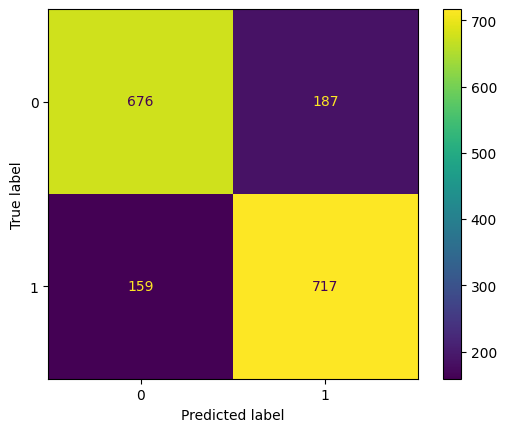

In [ ]:
fit_test_evaluate(catb, X_train, y_train, X_val, y_val, scores=True, class_report=True, confusion_mat=True)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.impute import KNNImputer

In [3]:
# Transform PassengerId into InGroup and GroupSize
class TransformPassengerId(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['GroupId'] = X['PassengerId'].str.split('_').str[0]
        X['PassengerNumber'] = X['PassengerId'].str.split('_').str[1].astype(float)
        group_counts = X['GroupId'].value_counts()
        X['GroupSize'] = X['GroupId'].map(group_counts)
        X['InGroup'] = np.where(X['GroupSize'] > 1, 1, 0)
        return X


# Transform Cabin into Deck, CabinPosition and Side 
class TransformCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['Deck'] = X['Cabin'].str.split('/').str[0]
        X['CabinNumber'] = X['Cabin'].str.split('/').str[1].astype(float)
        X['Side'] = X['Cabin'].str.split('/').str[2]
        bin_edges = np.linspace(X['CabinNumber'].min(), X['CabinNumber'].max(), 5)
        X['CabinPosition'] = pd.cut(X['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)
        return X


# Impute HomePlanet
class ImputeHomePlanet(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        group_modes = X.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = group_modes[X['HomePlanet'].isna()]

        deck_modes = X.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[X['HomePlanet'].isna()]

        if 'VIP' in X.columns:
            vip_mode_homePlanet = X.loc[X['VIP'] == True, 'HomePlanet'].mode().iloc[0]
            X.loc[X['VIP'] & X['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

        X['HomePlanet'].fillna(X['HomePlanet'].mode().iloc[0], inplace=True)

        return X


# Create proportional imputer and impute
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        impute_cols = ['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep']
        for col in impute_cols:
            proportions = X.groupby('HomePlanet')[col].value_counts(normalize=True)

            def impute_values(row):
                if pd.isna(row[col]):
                    group = row['HomePlanet']
                    if pd.notna(group) and group in proportions.index:
                        group_proportions = proportions.loc[group].dropna()
                        return np.random.choice(group_proportions.index, p=group_proportions.values)
                return row[col]
        
            X[col] = X.apply(impute_values, axis=1)
        return X


# KNN Imputer and transformer
class KNNImputerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        self.imputer = KNNImputer(n_neighbors=5)
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.columns] = self.imputer.transform(X[self.columns])
        return X


# Create TotalSpent column
class CreateTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpent'] = X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
        return X


# Convert binary classes to int 
class ToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        cols = ['InGroup', 'CryoSleep', 'VIP', 'Transported']
        for col in cols:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X


# Drop unwanted columns
class DropColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        droppers = ['PassengerNumber', 'GroupId', 'Cabin', 'CabinNumber', 'Name']
        X.drop(columns=droppers, inplace=True, errors='ignore')
        return X

In [14]:
def transform_impute(X):
    transform_pipe = Pipeline([
        ('TransformPassengerId', TransformPassengerId()),
        ('TransformCabin', TransformCabin()),
        ('ImputeHomePlanet', ImputeHomePlanet()),
        ('ProportionalImputer', ProportionalImputer()),
        ('KNNImputer', KNNImputerTransformer()),
        ('CreateTotalSpent', CreateTotalSpent()),
        ('ToInt', ToInt()),
        ('DropColumns', DropColumns())
    ])
    return transform_pipe.fit_transform(X)

prep_pipe = FunctionTransformer(transform_impute)

num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']
cat_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition','GroupSize']
bin_cols = ['InGroup','CryoSleep','VIP']

num_cols_pipe = Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
])

cat_cols_pipe = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

manipulator = ColumnTransformer([
    ('numeric_transforms', num_cols_pipe, num_cols),
    ('cat_transforms', cat_cols_pipe, cat_cols),
    ('binary_pass', 'passthrough', bin_cols)
])

full_pipe = Pipeline([
    ('transform_impute', prep_pipe),
    ('col_transform', manipulator),
    ('model', LogisticRegression(max_iter=1000))
])

In [7]:
train = pd.read_csv('../data/raw/train.csv')

target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.3, stratify=train[target], random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [12]:
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform_impute',
                 FunctionTransformer(func=<function transform_impute at 0x1294bd580>)),
                ('col_tranform',
                 ColumnTransformer(transformers=[('numeric_transforms',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpent']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'Destination',
                                                   'Deck', 'Side',
                                                   'CabinPosition',
                                                   'GroupSize']),
                                                 ('binary_pass', 'passthrough',
                                                  ['InGroup', 'CryoSleep',
                                                   'VIP'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [13]:
full_pipe.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('transform_impute',
                 FunctionTransformer(func=<function transform_impute at 0x1294bd580>)),
                ('col_tranform',
                 ColumnTransformer(transformers=[('numeric_transforms',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpent']),
                                                 ('cat_transforms',
                                     

In [15]:
from catboost import CatBoostClassifier

In [18]:
class CatBoostWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols, **catboost_params):
        self.cat_cols = cat_cols
        self.catboost_params = catboost_params
        self.model = CatBoostClassifier(**catboost_params)

    def fit(self, X, y=None):
        self.cat_features_indices = [i for i, col in enumerate(X.columns) if any(cat in col for cat in self.cat_cols)]
        self.model.set_params(cat_features=self.cat_features_indices)
        self.mode.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [19]:
catb_manipulator = ColumnTransformer([
    ('numeric_transforms', num_cols_pipe, num_cols),
    ('ohe_pass', 'passthrough', cat_cols),
    ('binary_pass', 'passthrough', bin_cols)
])

catb_full_pipe = Pipeline([
    ('transform_impute', prep_pipe),
    ('col_transform', catb_manipulator),
    ('model', CatBoostWrapper(cat_cols=cat_cols))
])


In [21]:
def get_catboost_cols(X):
    transformed_features = catb_manipulator.get_feature_names_out()
    cat_idxs = [i for i, col in enumerate(transformed_features) if any(cat in col for cat in cat_cols)]
    return cat_idxs

def to_dataframe(X, columns):
    return pd.DataFrame(X, columns=columns)

In [20]:
catb_full_pipe.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'